In [1]:
import os.path as osp
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch.hub
import os
import model
from PIL import Image
from torchvision import transforms
from torchsummary import summary
from visualize.grad_cam import BackPropagation, GradCAM,GuidedBackPropagation
from IPython import display
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

In [2]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def preprocess(image_path):
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path)
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    flag =0
    if len(faces) == 0:
        print('no face found')
        face = cv2.resize(image, shape)
    else:
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        face = cv2.resize(face, shape)
        flag=1

    img = Image.fromarray(face).convert('L')
    inputs = transform_test(img)
    return inputs, face, flag

def plotImage(path, mylabel):
    img = cv2.imread(path)
    dimensions = img.shape
    height = img.shape[0]
    width = img.shape[1]
    cv2.putText(img, mylabel,(round(width/2)-40,height-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    cv2.imwrite('Images/display.jpg',img) 
    img=mpimg.imread('Images/display.jpg')
    plt.imshow(img)
    display.clear_output(wait=True)
    display.display(plt.gcf())

def detect_emotion(images, model_name):
    flag=0
    with HiddenPrints():
        for i, image in enumerate(images):
            target, raw_image,flag = preprocess(image['path'])
            image['image'] = target
            image['raw_image'] = raw_image

        net = model.Model(num_classes=len(classes)).to(device)
        checkpoint = torch.load(os.path.join('trained', model_name), map_location=device)
        net.load_state_dict(checkpoint['net'])
        net.eval()
        summary(net, (1, shape[0], shape[1]))

        result_images = []
    label = ""
    if(flag):
        for index, image in enumerate(images):
            with HiddenPrints():
                img = torch.stack([image['image']]).to(device)
                bp = BackPropagation(model=net)
                probs, ids = bp.forward(img)
                actual_emotion = ids[:,0]
            label = classes[actual_emotion.data]
        plotImage(image['path'],label)
    else:
        plotImage(image['path'],label)

In [3]:
faceCascade = cv2.CascadeClassifier('visualize/haarcascade_frontalface_default.xml')
shape = (48,48)
classes = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Sad',
    'Surprised',
    'Neutral'
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

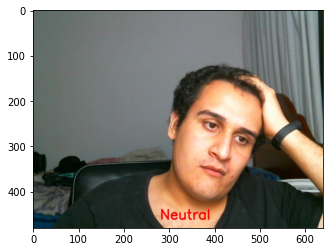

In [ ]:
video_capture = cv2.VideoCapture(0)
while 1:
    ret, frame = video_capture.read()
    cv2.imwrite('Images/test.jpg',frame)
    detect_emotion(images=[{'path': 'Images/test.jpg'}],model_name='private_model_233_66.t7')